<a href="https://colab.research.google.com/github/ValentineAlibert/Data-physics/blob/master/(final_part2)%20Notebook%20Valentine%20Alibert%2C%202nd%20exoplanet%20TIC%20ID%20%2325155310%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

second exoplanet :
TIC ID
#25155310
WASP-126 b

**When doing research I discovered that both of the exoplanet I found (WASP-119 b & WASP-129 b) were two transiting hot Jupite**r  

WASP-126 A is the brightest star presented here and also
hosts the lowest-mass planet in our sample (0.3 MJup). The radius of this planet is quite large (0.95 RJup) so it also has the
lowest surface gravity of these newly-discovered planets. This
combination of low surface gravity (i.e., large atmospheric scale
height) and a bright host star make this a good target for transmission spectroscopy.

## **Beginner: Cutout of the TESS FFIs using Astrocut and Astroquery**

In [209]:
import numpy as np
!pip install astroquery
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline

In [210]:
ticid = 25155310

starName = "TIC " + str(ticid)
radSearch = 4/60 #radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first row in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

    ID      Tmag   Jmag         ra               dec        objType
--------- ------- ------ ---------------- ----------------- -------
 25155310 10.6103  9.962 63.3739396231274  -69.226822697583    STAR
 25155316 14.2075 13.505 63.3850920409875 -69.2341587041183    STAR
684824398 18.7255    nan  63.375103342832 -69.2158491253879    STAR
 25155311 16.1547 15.261 63.4070407718992 -69.2268756200451    STAR
684824389 19.9173    nan 63.3998538603319 -69.2341784862086    STAR


In [211]:
# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 15

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)

11

In [212]:
coord = SkyCoord(ra, dec, unit = "deg")

sectorTable = Tesscut.get_sectors(coord)
print(sectorTable)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0001-4-1      1      4   1
tess-s0002-4-2      2      4   2
tess-s0003-4-2      3      4   2
tess-s0004-4-2      4      4   2
tess-s0005-4-3      5      4   3
tess-s0006-4-3      6      4   3
tess-s0007-4-3      7      4   3
tess-s0008-4-3      8      4   3
tess-s0009-4-4      9      4   4
tess-s0010-4-4     10      4   4
tess-s0011-4-4     11      4   4
tess-s0012-4-1     12      4   1
tess-s0013-4-1     13      4   1


In [0]:
hdulist = Tesscut.get_cutouts(coord, 20)

In [214]:
hdulist[0].info()
hdulist[0][0].header['SECTOR']
#hdulist[1].info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   


1

In [0]:

def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')

Text(0, 0.5, 'Image Row')

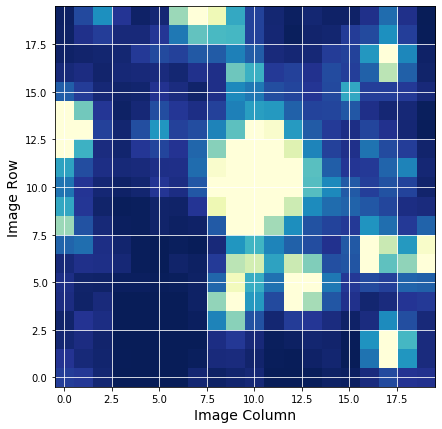

In [216]:
hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage)
plt.xlabel('Image Column',fontsize = 14)
plt.ylabel('Image Row',fontsize = 14)

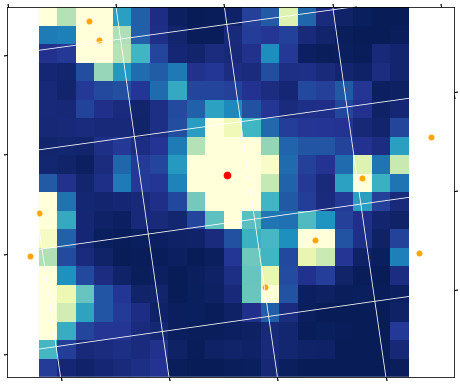

In [217]:
hdu2 = hdulist[1]

firstImage = hdu2[1].data['FLUX'][0]

wcs = WCS(hdu2[2].header)

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(111, projection = wcs)
plot_cutout(firstImage)

plt.xlabel('RA', fontsize = 12)
plt.ylabel('Dec', fontsize = 12)


starloc = wcs.all_world2pix([[ra,dec]],0)  #Second is origin
plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:],0)
plt.scatter(nearbyLoc[1:, 0], nearbyLoc[1:, 1], 
            s = 25, color = 'orange')

In [0]:
def aperture_phot(image, aperture):
    """
    Sum-up the pixels that are in the aperture for one image.
    image and aperture are 2D arrays that need to be the same size.
    
    aperture is a boolean array where True means to include the light of those pixels.
    """
    flux = np.sum(image[aperture])

    return flux

def make_lc(flux_data, aperture):
    """
    Apply the 2d aperture array to the and time series of 2D images. 
    Return the photometric series by summing over the pixels that are in the aperture.
    
    Aperture is a boolean array where True means it is in the desired aperture.
    """
    
    flux = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )

    return flux

Text(0.5, 1.0, 'Flux in Photometric Aperture')

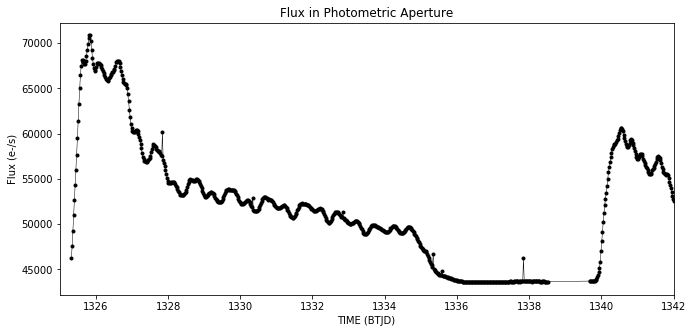

In [219]:
aperture = hdu1[2].data == 1

flux1 = make_lc(hdu1[1].data['FLUX'], aperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11,5))
plt.plot(time1, flux1, 'k.-', lw = .5)
plt.xlim(1325,1342)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Flux in Photometric Aperture')

Text(0.5, 1.0, 'Background Flux')

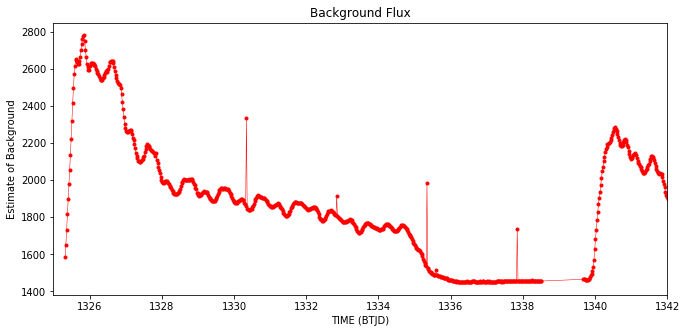

In [220]:

bkgAperture = hdu1[1].data['FLUX'][0] < np.percentile(hdu1[1].data['FLUX'][0], 5)

bkgFlux1 = make_lc(hdu1[1].data['FLUX'], bkgAperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11, 5))
plt.plot(time1, bkgFlux1, 'r.-', lw = .5)

plt.xlim(1325, 1342)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Estimate of Background')
plt.title('Background Flux')

Text(0.5, 1.0, 'Background Subtracted Flux')

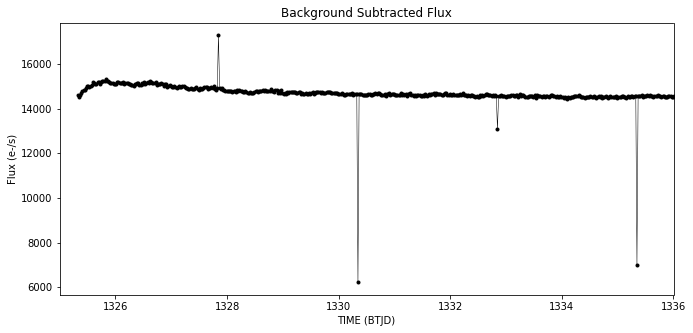

In [221]:
bkgSubFlux = flux1 - (bkgFlux1 * np.sum(aperture) / np.sum(bkgAperture) )

plt.figure(figsize = (11,5))
plt.plot(time1, bkgSubFlux,'.-k', lw = 0.5)

plt.xlim(1325, 1336)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Background Subtracted Flux')

# **Discussion TIC 25155310**
This is a Confirmed Planet and its Name is WASP-119 b.
In the last graph, we can observe four outliers in the background substarcted flux. We can see that both two points are periodic and in fact in the informations we can found that there are two confirmed planets orbiting this star. What not normal is that two of the outliers are periodic but not on the part of the flux scale. They might be random point errros.

And also in the light curve graph, it is found to be a well and with four pics, representing different flux and thus if it periodic it would mean that there is a planet passing in front of the star. Two of the points are periodic and thus mean that there is one exoplanet. But the other two points are a bit random.


## **Exoplanet Data and TESS Light Curves Using Python Requests**

In [0]:
import numpy as np
import requests
import matplotlib.pyplot as plt
import pandas as p
from IPython.display import display, HTML

%matplotlib inline

planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
dvurl = "https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/"
header={}

In [223]:
planet_name = "WASP-126 b"

url = planeturl + "/identifiers/"

myparams = {"name":planet_name}

r = requests.get(url = url, params = myparams, headers = header)
print(r.headers.get('content-type'))

application/json; charset=UTF-8


In [224]:
planet_names = r.json()
ticid = planet_names['tessID']
tce = planet_names['tessTCE']
planet_names

{'canonicalName': 'WASP-126 b',
 'dec': -69.226807,
 'keplerID': None,
 'keplerTCE': None,
 'planetNames': [],
 'ra': 63.373865,
 'starName': 'WASP-126',
 'tessID': 25155310,
 'tessTCE': 'TCE_1'}

In [225]:
url = planeturl + planet_name + "/properties/"

r = requests.get(url = url, headers = header)

planet_prop = r.json()

print("Catalog 1: " + planet_prop[0]['catalog_name'])
print("Catalog 2: " + planet_prop[1]['catalog_name'])
planet_prop[0].keys()

Catalog 1: nexsci
Catalog 2: exoplanets.org


dict_keys(['canonical_name', 'exoplanetID', 'catalog_name', 'planet_name', 'disposition', 'modified_date', 'star_name', 'component', 'Rs', 'Rs_unit', 'Rs_upper', 'Rs_lower', 'Rs_ref', 'Rs_url', 'Ms', 'Ms_unit', 'Ms_upper', 'Ms_lower', 'Ms_ref', 'Ms_url', 'Fe/H', 'Fe/H_upper', 'Fe/H_lower', 'Fe/H_ref', 'Fe/H_url', 'stellar_gravity', 'stellar_gravity_upper', 'stellar_gravity_lower', 'stellar_gravity_ref', 'stellar_gravity_url', 'Teff', 'Teff_unit', 'Teff_upper', 'Teff_lower', 'Teff_ref', 'Teff_url', 'Vmag', 'Vmag_unit', 'Vmag_upper', 'Vmag_lower', 'Vmag_ref', 'Vmag_url', 'Jmag', 'Jmag_unit', 'Jmag_upper', 'Jmag_lower', 'Jmag_ref', 'Jmag_url', 'Hmag', 'Hmag_unit', 'Hmag_upper', 'Hmag_lower', 'Hmag_ref', 'Hmag_url', 'Kmag', 'Kmag_unit', 'Kmag_upper', 'Kmag_lower', 'Kmag_ref', 'Kmag_url', 'RA', 'DEC', 'distance', 'distance_unit', 'distance_upper', 'distance_lower', 'distance_ref', 'distance_url', 'Rp', 'Rp_unit', 'Rp_upper', 'Rp_lower', 'Rp_ref', 'Rp_url', 'Mp', 'Mp_unit', 'Mp_upper', 'Mp_l

In [226]:
print("WASP-126 b Properties")
print("Stellar Mass %f %s" % (planet_prop[0]['Ms'], planet_prop[0]['Ms_unit'] ) )
print("Planet Mass %f %s" % (planet_prop[0]['Mp'], planet_prop[0]['Mp_unit'] ) )
print("Planet Mass Reference: %s" % (planet_prop[0]['Mp_ref']))

WASP-126 b Properties
Stellar Mass 1.120000 M_sun
Planet Mass 0.284110 M_Jupiter
Planet Mass Reference: Pearson 2019


In [227]:
url = dvurl + str(ticid) + '/tces/'
myparams = {"tce" : tce}

r = requests.get(url = url, params = myparams, headers = header)
sectorInfo = r.json()

sectors = [x[:11] for x in sectorInfo["TCE"] if tce in x]
sectors

['s0005-s0005',
 's0001-s0003',
 's0002-s0002',
 's0013-s0013',
 's0008-s0008',
 's0001-s0001',
 's0012-s0012',
 's0011-s0011',
 's0001-s0006',
 's0001-s0009',
 's0003-s0003',
 's0006-s0006',
 's0009-s0009',
 's0010-s0010',
 's0001-s0002',
 's0007-s0007',
 's0004-s0004',
 's0001-s0013']

In [228]:
url = dvurl + str(ticid) + '/info/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tceInfo = r.json()
tceInfo.keys()
tceInfo['DV Data Header'].keys()

print("TIC: %s" % tceInfo['DV Primary Header']['OBJECT'])
print("Planet Radius: %f" % tceInfo['DV Data Header']['PRADIUS'])

TIC: TIC 25155310
Planet Radius: 10.705177


In [0]:
# Get The data
url = dvurl + str(ticid) + '/table/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tce_data = r.json()

In [230]:
data = p.DataFrame.from_dict(tce_data['data'])
data.columns

Index(['TICID', 'EXTNAME', 'TIME', 'TIMECORR', 'CADENCENO', 'PHASE', 'LC_INIT',
       'LC_INIT_ERR', 'LC_WHITE', 'LC_DETREND', 'MODEL_INIT', 'MODEL_WHITE',
       'DATE_OBS', 'TESSDatetime', 'SECTORS'],
      dtype='object')

Text(0, 0.5, 'Relative Flux')

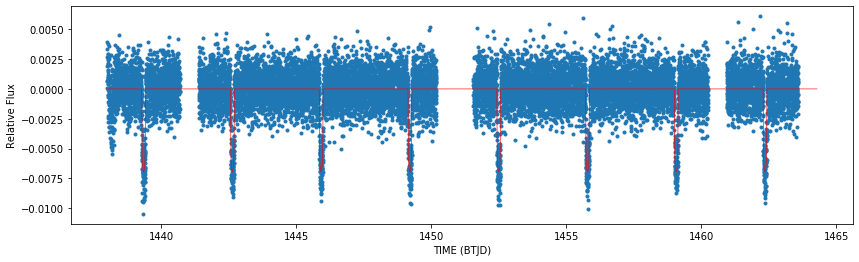

In [231]:
detrend = data['LC_DETREND']
model = data['MODEL_INIT']
time = data['TIME']

plt.figure(figsize=(14,4))
plt.plot(time,detrend,'.',lw=0.4)
plt.plot(time,model,'r-',lw=0.6)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Relative Flux')

In [0]:
url = dvurl + str(ticid) + '/phaseplot/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)

In [233]:
display(HTML(str(r.content.decode('utf-8'))))

## **Beginner: Retrieve TESS Data Validation Products with Astroquery**

In [234]:
!pip install astroquery
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy import table
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

In [235]:
star_name = "WASP-126 b"

observations = Observations.query_object(star_name,radius = "0 deg")
obs_wanted = (observations['dataproduct_type'] == 'timeseries') & (observations['obs_collection'] == 'TESS')
print( observations[obs_wanted]['obs_collection', 'project','obs_id'] )

obs_collection project                        obs_id                       
-------------- ------- ----------------------------------------------------
          TESS    TESS      tess2018206045859-s0001-0000000025155310-0120-s
          TESS    TESS tess2018206190142-s0001-s0002-0000000025155310-00111
          TESS    TESS tess2018206190142-s0001-s0003-0000000025155310-00129
          TESS    TESS tess2018206190142-s0001-s0006-0000000025155310-00196
          TESS    TESS tess2018206190142-s0001-s0009-0000000025155310-00205
          TESS    TESS tess2018206190142-s0001-s0013-0000000025155310-00226
          TESS    TESS      tess2018234235059-s0002-0000000025155310-0121-s
          TESS    TESS      tess2018263035959-s0003-0000000025155310-0123-s
          TESS    TESS      tess2018292075959-s0004-0000000025155310-0124-s
          TESS    TESS      tess2018319095959-s0005-0000000025155310-0125-s
          TESS    TESS      tess2018349182459-s0006-0000000025155310-0126-s
          TE

In [236]:
data_products = Observations.get_product_list(observations[obs_wanted])
products_wanted = Observations.filter_products(data_products, 
                                    productSubGroupDescription=["DVT","DVM","DVS","DVR"])

print(products_wanted["productFilename"])
manifest = Observations.download_products(products_wanted)

                        productFilename                        
---------------------------------------------------------------
   tess2018206190142-s0001-s0001-0000000025155310-00106_dvr.pdf
   tess2018206190142-s0001-s0001-0000000025155310-00106_dvr.xml
   tess2018206190142-s0001-s0001-0000000025155310-00106_dvm.pdf
tess2018206190142-s0001-s0001-0000000025155310-01-00106_dvs.pdf
  tess2018206190142-s0001-s0001-0000000025155310-00106_dvt.fits
   tess2018206190142-s0001-s0002-0000000025155310-00111_dvr.pdf
   tess2018206190142-s0001-s0002-0000000025155310-00111_dvr.xml
   tess2018206190142-s0001-s0002-0000000025155310-00111_dvm.pdf
tess2018206190142-s0001-s0002-0000000025155310-01-00111_dvs.pdf
  tess2018206190142-s0001-s0002-0000000025155310-00111_dvt.fits
                                                            ...
  tess2019113062933-s0011-s0011-0000000025155310-00214_dvt.fits
   tess2019141104532-s0012-s0012-0000000025155310-00219_dvr.pdf
   tess2019141104532-s0012-s0012-0000000

In [237]:
print( manifest['Local Path'] )

                                                               Local Path                                                               
----------------------------------------------------------------------------------------------------------------------------------------
        ./mastDownload/TESS/tess2018206045859-s0001-0000000025155310-0120-s/tess2018206190142-s0001-s0001-0000000025155310-00106_dvr.pdf
        ./mastDownload/TESS/tess2018206045859-s0001-0000000025155310-0120-s/tess2018206190142-s0001-s0001-0000000025155310-00106_dvr.xml
        ./mastDownload/TESS/tess2018206045859-s0001-0000000025155310-0120-s/tess2018206190142-s0001-s0001-0000000025155310-00106_dvm.pdf
     ./mastDownload/TESS/tess2018206045859-s0001-0000000025155310-0120-s/tess2018206190142-s0001-s0001-0000000025155310-01-00106_dvs.pdf
       ./mastDownload/TESS/tess2018206045859-s0001-0000000025155310-0120-s/tess2018206190142-s0001-s0001-0000000025155310-00106_dvt.fits
   ./mastDownload/TESS/tess2018206190142-

In [238]:
def parse_manifest(manifest):
    """
    Parse manifest and add back columns that are useful for TESS DV exploration.
    """
    results = deepcopy(manifest)
    filenames = []
    sector_range = []
    exts = []
    for i,f in enumerate(manifest['Local Path']):
        file_parts = np.array(np.unique(f.split(sep = '-')))
        sectors = list( map ( lambda x: x[0:2] == 's0', file_parts))
        s1 = file_parts[sectors][0]
        try:
            s2 = file_parts[sectors][1]
        except:
            s2 = s1
        sector_range.append("%s-%s" % (s1,s2))
        path_parts = np.array(f.split(sep = '/'))
        filenames.append(path_parts[-1])
        exts.append(path_parts[-1][-8:])

    results.add_column(table.Column(name = "filename", data = filenames))
    results.add_column(table.Column(name = "sectors", data = sector_range))
    results.add_column(table.Column(name = "fileType", data = exts))
    results.add_column(table.Column(name = "index", data = np.arange(0,len(manifest))))
    
    return results

#Run parser and print
results = parse_manifest(manifest)
print(results['index','sectors','fileType'])

index   sectors   fileType
----- ----------- --------
    0 s0001-s0001 _dvr.pdf
    1 s0001-s0001 _dvr.xml
    2 s0001-s0001 _dvm.pdf
    3 s0001-s0001 _dvs.pdf
    4 s0001-s0001 dvt.fits
    5 s0001-s0002 _dvr.pdf
    6 s0001-s0002 _dvr.xml
    7 s0001-s0002 _dvm.pdf
    8 s0001-s0002 _dvs.pdf
    9 s0001-s0002 dvt.fits
  ...         ...      ...
   79 s0011-s0011 dvt.fits
   80 s0012-s0012 _dvr.pdf
   81 s0012-s0012 _dvr.xml
   82 s0012-s0012 _dvm.pdf
   83 s0012-s0012 _dvs.pdf
   84 s0012-s0012 dvt.fits
   85 s0013-s0013 _dvr.pdf
   86 s0013-s0013 _dvr.xml
   87 s0013-s0013 _dvm.pdf
   88 s0013-s0013 _dvs.pdf
   89 s0013-s0013 dvt.fits
Length = 90 rows


In [239]:
print(results['index', 'sectors', 'fileType'][results['sectors'] == "s0001-s0013"])

index   sectors   fileType
----- ----------- --------
   25 s0001-s0013 _dvr.pdf
   26 s0001-s0013 _dvr.xml
   27 s0001-s0013 _dvm.pdf
   28 s0001-s0013 _dvs.pdf
   29 s0001-s0013 dvt.fits


In [240]:
# Locate the file that has the data
want = (results['sectors'] == "s0001-s0013") & (results['fileType'] == "dvt.fits")
dvt_filename = manifest[want]['Local Path'][0]

# Print out the file info
fits.info(dvt_filename)

Filename: ./mastDownload/TESS/tess2018206190142-s0001-s0013-0000000025155310-00226/tess2018206190142-s0001-s0013-0000000025155310-00226_dvt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   ()      
  1  TCE_1         1 BinTableHDU     92   257086R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  2  Statistics    1 BinTableHDU    157   257086R x 38C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


Text(0.5, 1.0, 'Data Validation Detrended Light Curve for WASP-126 b')

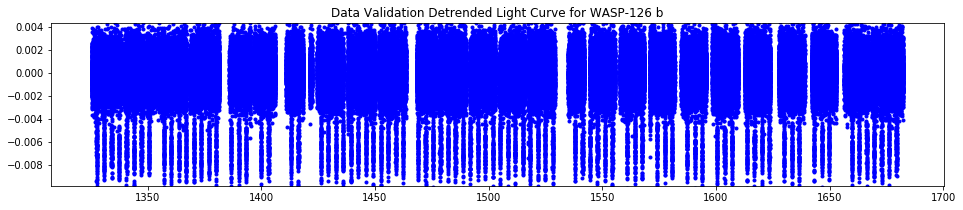

In [241]:
# Plot the detrended photometric time series in the first binary table. 
data = fits.getdata(dvt_filename, 1)
time = data['TIME']
relflux = data['LC_DETREND']

plt.figure(figsize = (16,3))
plt.plot (time, relflux, 'b.')
plt.ylim(1.2* np.nanpercentile(relflux, .5) , 1.2 * np.nanpercentile(relflux, 99.5))
plt.title('Data Validation Detrended Light Curve for %s' % (star_name))

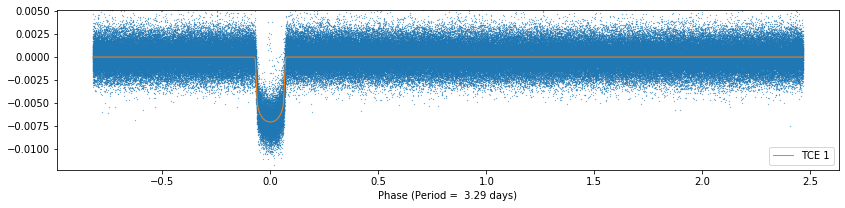

In [242]:
def plot_folded(phase, data, model, ext, period):
    isort = phase.argsort()
    
    plt.plot(phase[isort], data[isort], '.', ms = .5)
    plt.plot(phase[isort], model[isort], '-', lw = 1, label = "TCE %i" % ext)
    plt.xlabel('Phase (Period = %5.2f days)' % period)
    plt.ylim(1.5 * np.nanpercentile(data, .5) , 1.4 * np.nanpercentile(data,99.5))
    plt.legend(loc = "lower right")

plt.figure(figsize = (14,10))

nTCEs = fits.getheader(dvt_filename)['NEXTEND'] - 2

for ext in range(1, nTCEs + 1):
    data = fits.getdata(dvt_filename, ext)
    head = fits.getheader(dvt_filename, ext)
    period = head['TPERIOD']
    phase = data['PHASE']
    flux = data['LC_INIT']
    model = data['MODEL_INIT']
    plt.subplot(3, 1, ext)
    plot_folded(phase, flux, model, ext, period)

Intermediate: Finding Flares and Variable Stars in TASC Light **Curves**

In [243]:
!pip install astroquery
# For querying for data
from astroquery.mast import Tesscut, Observations, Catalogs

# For manipulating data
import numpy as np
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.timeseries import LombScargle
from astropy.time import Time
import astropy.units as u

# For matplotlib plotting
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# For animation display
from matplotlib import rc
from IPython.display import HTML
rc('animation', html='jshtml')

# For bokeh plotting
from bokeh import plotting
from bokeh.models import Span
plotting.output_notebook()

In [0]:
tic_id = 25155310
sector = 1


tpeak = 2458341.89227 # Julian Day

In [245]:
tasoc_res = Observations.query_criteria(target_name=tic_id, 
                                        obs_collection="HLSP", 
                                        project="TESS",
                                        sequence_number=sector)
tasoc_res['dataproduct_type',"obs_collection","target_name","t_exptime","filters",
          "provenance_name","project","sequence_number","instrument_name"]

dataproduct_type,obs_collection,target_name,t_exptime,filters,provenance_name,project,sequence_number,instrument_name
str10,str4,str8,float64,str4,str5,str4,int64,str10
timeseries,HLSP,25155310,120.0,TESS,TASOC,TESS,1,Photometer
timeseries,HLSP,25155310,1800.0,TESS,TASOC,TESS,1,Photometer


In [246]:
tasoc_prod = Observations.get_product_list(tasoc_res)
tasoc_prod["dataproduct_type", "description", "dataURI", "size"]

dataproduct_type,description,dataURI,size
str10,str4,str107,int64
timeseries,FITS,mast:HLSP/tasoc/s0001/tpf/0000/0000/2515/5310/hlsp_tasoc_tess_ffi_tic00025155310-s01-c0120_tess_v04_lc.fits,1877760
timeseries,FITS,mast:HLSP/tasoc/s0001/ffi/0000/0000/2515/5310/hlsp_tasoc_tess_ffi_tic00025155310-s01-c1800_tess_v04_lc.fits,161280


In [247]:
tasoc_manifest = Observations.download_products(tasoc_prod)
tasoc_manifest

Local Path,Status,Message,URL
str138,str8,object,object
./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00025155310-s01-c0120_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00025155310-s01-c0120_tess_v04_lc.fits,COMPLETE,None,None
./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00025155310-s01-c1800_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00025155310-s01-c1800_tess_v04_lc.fits,ERROR,HTTPError: 504 Server Error: Gateway Time-out for url: https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:HLSP/tasoc/s0001/ffi/0000/0000/2515/5310/hlsp_tasoc_tess_ffi_tic00025155310-s01-c1800_tess_v04_lc.fits,https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:HLSP/tasoc/s0001/ffi/0000/0000/2515/5310/hlsp_tasoc_tess_ffi_tic00025155310-s01-c1800_tess_v04_lc.fits


In [267]:
# Loading the short cadence light curve
hdu = fits.open(tasoc_manifest["Local Path"][0])
short_cad_lc = Table(hdu[1].data)
hdu.close()

# Loading the long cadence light curve
hdu = fits.open(tasoc_manifest["Local Path"][1])
long_cad_lc = Table(hdu[1].data)
hdu.close()

# Short cadence
bfig.circle(short_cad_lc["TIME"],short_cad_lc["FLUX_RAW"], fill_color="black",size=2, line_color=None)
bfig.line(short_cad_lc["TIME"],short_cad_lc["FLUX_RAW"], line_color='black')

# Long cadence
bfig.circle(long_cad_lc["TIME"],long_cad_lc["FLUX_RAW"], fill_color="#0384f7",size=6, line_color=None)
bfig.line(long_cad_lc["TIME"],long_cad_lc["FLUX_RAW"], line_color='#0384f7')

# Marking the flare (tpeak is in BJD, while the time column in the light curve is BTJD, so we must convert)
vline = Span(location=(tpeak - 2457000), dimension='height', line_color='#bf006e', line_width=3)
bfig.renderers.extend([vline])

# Labeling the axes
bfig.xaxis.axis_label = "Time (BTJD)"
bfig.yaxis.axis_label = "Flux"

plotting.show(bfig)

FileNotFoundError: ignored

In [0]:
#animation

coord = Observations.resolve_object(f"TIC {tic_id}")

In [0]:
cutout_hdu = Tesscut.get_cutouts(coordinates=coord, size=40, sector=1)[0]

In [263]:
cutout_hdu.info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 1600J, 1600E, 1600E, 1600E, 1600E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (40, 40)   int32   


In [264]:
cutout_table.columns

NameError: ignored

In [265]:
start_btjd = 1341.5
end_btjd = 1342.5

start_index = (np.abs(cutout_table['TIME'] - start_btjd)).argmin()
end_index = (np.abs(cutout_table['TIME'] - end_btjd)).argmin()

print(f"Frames {start_index}-{end_index} ({end_index-start_index} frames)")

NameError: ignored

In [266]:
make_animation(cutout_table['FLUX'], start_index, end_index, vmax=700, delay=150)

NameError: ignored

In [0]:
#exploring variable stars
sources = Catalogs.query_object(catalog="TIC", objectname=f"TIC {tic_id}", radius=10*u.arcmin)
sources = sources[sources["Tmag"] < 12]
print(f"Number of sources: {len(sources)}")
print(sources)

In [0]:
cutout_wcs = WCS(cutout_hdu[2].header)
cutout_img = cutout_table["FLUX"][start_index]

In [0]:
fig, ax = plt.subplots(subplot_kw={'projection':cutout_wcs})
fig.set_size_inches(10,10)
plt.grid(color='white', ls='solid')
    
# Setup WCS axes.
xcoords = ax.coords[0]
ycoords = ax.coords[1]
xcoords.set_major_formatter('d.ddd')
ycoords.set_major_formatter('d.ddd')
xcoords.set_axislabel("RA (deg)")
ycoords.set_axislabel("Dec (deg)")
ax.imshow(cutout_img, cmap=plt.cm.YlGnBu_r,vmin=0,vmax=700)
ax.plot(sources['ra'],sources['dec'],'x',transform=ax.get_transform('icrs'),color="red")

# Annotating the sources with their row nnumber in the sources table
for i,star in enumerate(sources):
    ax.text(star['ra']+0.01,star['dec'],i,transform=ax.get_transform('icrs'))

ax.set_xlim(0,cutout_img.shape[1]-1)
ax.set_ylim(cutout_img.shape[0]-1,0)

plt.show()

In [0]:
sources["ID","ra","dec"][4]

In [0]:
#get the variable star curve
variable_tic_id = sources["ID"][4]

variable_res = Observations.query_criteria(target_name=variable_tic_id, 
                                        obs_collection="HLSP", 
                                        filters="TESS")
print(f"Number of tasoc light curves for {variable_tic_id}: {len(variable_res)}\n")

        
variable_prod = Observations.get_product_list(variable_res[0])
variable_manifest = Observations.download_products(variable_prod)

In [0]:
hdu = fits.open(variable_manifest["Local Path"][0])
variable_lc = Table(hdu[1].data)
hdu.close()

In [0]:
#plot the variable star light curve

bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Detrended Lightcurve (TIC{variable_tic_id})")

bfig.circle(variable_lc["TIME"],variable_lc["FLUX_RAW"], fill_color="black",size=4, line_color=None)
bfig.line(variable_lc["TIME"],variable_lc["FLUX_RAW"], line_color='black')

# Labeling the axes
bfig.xaxis.axis_label = "Time (BTJD)"
bfig.yaxis.axis_label = "Flux"

plotting.show(bfig)

In [0]:
lomb = LombScargle(variable_lc["TIME"], variable_lc["FLUX_RAW"])
frequency, power = lomb.autopower(maximum_frequency=25)

In [0]:
#plot the periodrogram

bfig = plotting.figure(plot_width=850, plot_height=300, x_range=(0,25),
                       title=f"Periodogram (TIC{variable_tic_id})")

bfig.line(frequency, power, line_color='black')

# Labeling the axes
bfig.xaxis.axis_label = "Frequency (1/day)"
bfig.yaxis.axis_label = "Power"

plotting.show(bfig)

In [0]:
#phase highest and lowest frequency

dominant_freq = frequency[np.argmax(power)].value
print(f"The dominant priod: {1/dominant_freq*24:.3} hours")

In [0]:
bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Phased Lightcurve (TIC{variable_tic_id})")

# Plotting the phased light curve
bfig.circle(variable_lc["TIME"]%(1/dominant_freq),variable_lc["FLUX_RAW"], fill_color="black",size=4, line_color=None)

# Plotting the periodic fit
t_fit = np.linspace(0,1/dominant_freq,100)
bfig.line(t_fit, lomb.model(t_fit, dominant_freq), color='#1b9f00', line_width=2)

# Labeling the axes
bfig.xaxis.axis_label = "Phase (days)"
bfig.yaxis.axis_label = "Flux"

plotting.show(bfig)

## **Interactively inspecting Target Pixel Files and Lightcurves (tesslightkurve file)**

In [0]:
!pip install 'lightkurve'
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
from lightkurve import search_targetpixelfile
f = search_targetpixelfile(388104547, quarter=0).download()

In [0]:
tpf.interact(notebook_url='localhost:8893')

In [0]:
import lightkurve as lk
search = lk.search_targetpixelfile("Pi Mensae", sector=1)
tpf = search.download()

In [0]:
# Loop through three different threshold values to build three masks
for idx, threshold in enumerate([1, 10, 100]):
    # Append them to a list
    apers.append(tpf.create_threshold_mask(threshold=threshold))

In [0]:
apers[0]

In [0]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Loop through the aperture masks
for idx, aper in enumerate(apers):
    # Use lightkurve to plot each tpf with each mask.
    tpf.plot(ax=axs[idx], aperture_mask=aper)